# Pole Figures from ALS

### Import python libraries

In [1]:
# numpy and plotting
import numpy as np
from scipy.signal import convolve2d, medfilt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Data handling
import os
import glob
import pandas as pd

# pyFAI
import pyFAI
from pyFAI.multi_geometry import MultiGeometry
from pyFAI.calibrant import get_calibrant
# from pyFAI.gui import jupyter

# pygix
import pygix
import fabio
from pygix import plotting as ppl

# Peak Fitting
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel

# Fix MPL params
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 12
                })
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 96

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data files

In [2]:
base_folder = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl"
gb_glob = glob.glob(os.path.join(base_folder,'*.gb'))
edf_glob = glob.glob(os.path.join(base_folder,'*.edf'))
txt_glob = glob.glob(os.path.join(base_folder,'*.txt'))
gb_glob

['\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p080_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p100_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p120_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p140_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p160_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p180_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p200_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzy

<IPython.core.display.Javascript object>


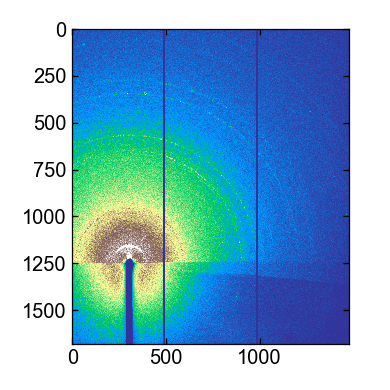

In [3]:
%matplotlib notebook
im_shape = fabio.open(edf_glob[0]).data.shape
raw1 = np.fromfile(gb_glob[0], dtype=np.float32)
raw1 = raw1.reshape(im_shape)
clim = np.percentile(raw1, (2, 99.9))
plt.imshow(raw1, cmap='terrain', vmin=clim[0], vmax=clim[1])

### Define pyFai detector parameters

In [4]:
def setup_detector(data):
    # Setup detector and transform
    ### Detector pixel size
    det_pix = [172e-6, 172e-6]
    detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

    ### Wavelength
    wl = 1.23984e-10

    ### Center-pixel and sample-to-detector distance
    centerx =  304.831
    centery = 1244.7   # This is because I had to flip it upside-down
    sdd = 249.376e-3

    ### Beamcenter from sample view in meters from lower left of detector
    poni1 = centery * det_pix[1]; poni2 = centerx * det_pix[0]

    ### detector rotations from sample view
    rot1 = 0.0 /180 * np.pi # move detector to right, in-plane angle# in radians
    rot2 = 0.0 /180 * np.pi # move detector down, out-of-plane angle
    rot3 = 180 /180 * np.pi # clockwise rotation

    ### Orientations and Angles
    sample_orientation = 1    # 1 is horizontal, 2 is vertical
    incident_angle = 0.24   # indicent angle in deg
    tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")
    
    ### Initialize the transform
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)
    
    return pg

In [5]:
def show_sample_file(filename, prctile=(2,99.5), newfig=True):
    
    # Inputs:
    # filename: path to tiff file you want to see
    # prctile: the percentiles of image intensity where you want the lower and upper bounds on the color scale
    # set newfig to false if you're using this as part of a subplot
    
    raw = np.fromfile(gb_glob[0], dtype=np.float32).reshape(im_shape)
    
    # setup_detector defines a transform with the parameters I got from calibration
    pg = setup_detector(raw)
    
    # Generate the corrected image
    # get_raw loads the tif file and 3x3 median-filters it (de-zinger)
    imgt, qxy, qz = pg.transform_reciprocal(raw,
                                            method='lut',
                                            correctSolidAngle=True,
                                            unit='A')
    corr_img = imgt-np.min(imgt)+1
    log_img = np.log(corr_img)
    
    # Calculate where the color scale should be bounded
    clim = np.percentile(log_img[log_img>0], prctile)
    
    if newfig:
        plt.figure(figsize=(5,5))
    
    # pygix built-in plotting with nice formatting
    ppl.implot(log_img, qxy, qz, mode='rsma',
               cmap="terrain", clim=clim,
               xlim=(-1,1), ylim=(-0.1,1),
               newfig=False)
    
    return raw, imgt

<IPython.core.display.Javascript object>


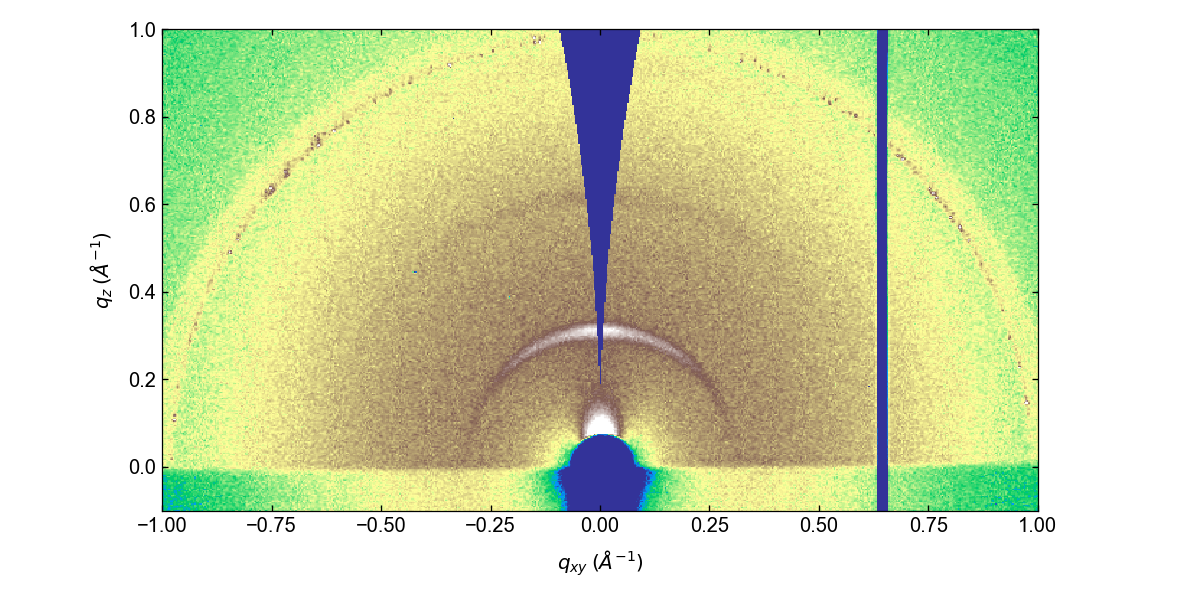

typ: center
unit: q_A^-1
typ: delta
unit: q_A^-1
pos0 shape: (1679, 1475)
dpos0 shape: (1679, 1475)
pos1 shape: (1679, 1475)
dpos1 shape: (1679, 1475)
npt: (1475, 1679)
pos0Range: (-0.14877706887636064, 0.3374524180991339)
pos1Range: (-0.14517423783795752, 0.33053662481932206)
mask: None
mask_checksum: None


C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [6]:
plt.figure(figsize=(10,5))
raw, transformed = show_sample_file(gb_glob[0], newfig=False, prctile=(60,99.99))
plt.savefig('benzyl_example.png')

In [7]:
transformed.shape

(1679, 1475)

In [1]:
raw = np.fromfile(gb_glob[0], dtype=np.float32).reshape(im_shape)
pg = setup_detector(raw)

intensity, q_abs, chi = pg.transform_polar(raw, unit='A',
                                           npt=(180, 180),
                                           chi_range=(-220,-160), q_range=(0,2),
                                           correctSolidAngle=True,
                                           method='lut')

vmin, vmax = np.percentile(intensity, (1,99))

plt.figure(figsize=(5,5))
plt.imshow(intensity, cmap='terrain',
           vmin=vmin, vmax=vmax,
           extent = [q_abs.min(), q_abs.max(), chi.min(), chi.max()],
           aspect='auto')
plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel(r'$\chi \: (deg.)$')
# plt.savefig('benzyl_q_chi_example.png')

NameError: name 'np' is not defined

[41 52]
[37 56]


<IPython.core.display.Javascript object>


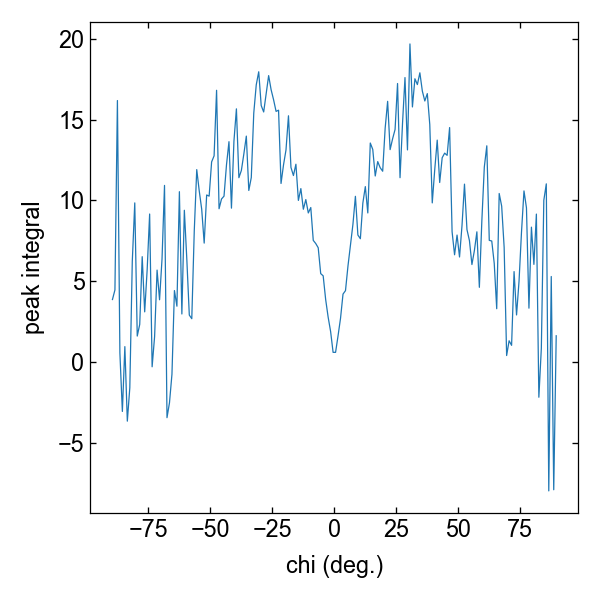

Text(0,0.5,'peak integral')

In [131]:
qb = (0.275, 0.345)
q_pix = np.array([np.where(q_abs>qb[0])[0][0], np.where(q_abs>qb[1])[0][0]])
qbg = qb + np.array([-1, 1])*0.03
q_bg_pix = np.array([np.where(q_abs>qbg[0])[0][0], np.where(q_abs>qbg[1])[0][0]])


print(q_pix)
print(q_bg_pix)


cut = intensity[:,q_pix[0]:q_pix[1]].sum(axis=1)/np.diff(q_pix) - np.mean(intensity[:,q_bg_pix], axis=1)

plt.figure(figsize=(5,5))
plt.plot(chi,cut * np.abs(np.sin(chi * np.pi / 180)))
plt.xlabel('chi (deg.)')
plt.ylabel('peak integral')

<IPython.core.display.Javascript object>


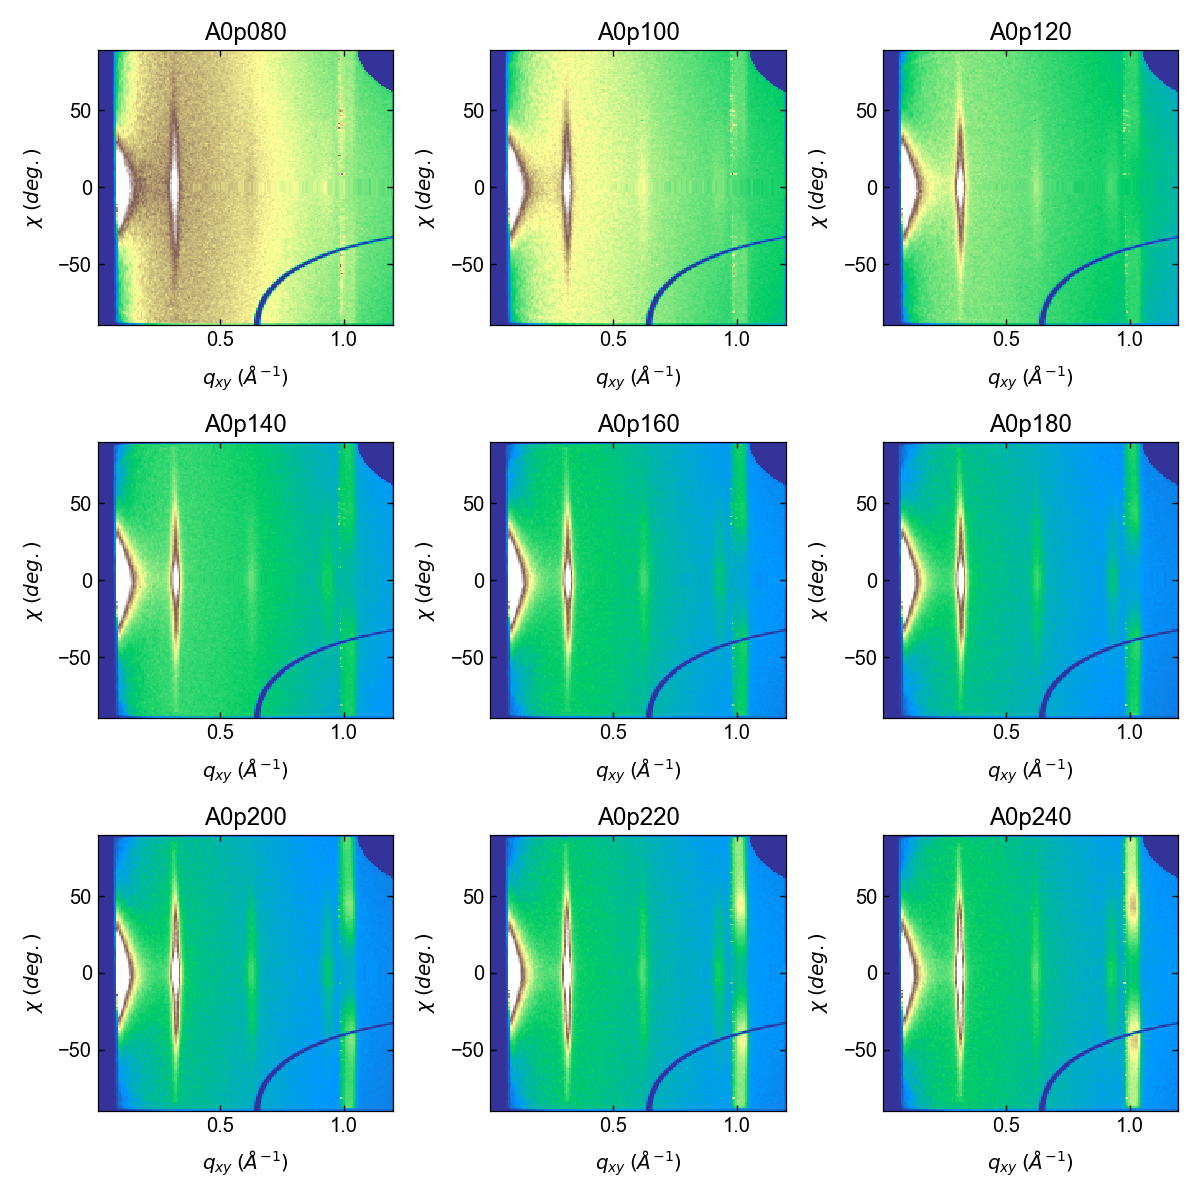

In [147]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, file in enumerate(gb_glob):
    
    raw = np.fromfile(gb_glob[i], dtype=np.float32).reshape(im_shape)
    pg = setup_detector(raw)

    intensity, q_abs, chi = pg.transform_polar(raw, unit='A',
                                               npt=(180, 180),
                                               chi_range=(-90,90), q_range=(0,1.2),
                                               correctSolidAngle=True,
                                               method='splitpix')

    vmin, vmax = np.percentile(intensity, (1,99))
    
    plt.subplot(3,3,i+1)
    plt.imshow(intensity, cmap='terrain',
               vmin=vmin, vmax=vmax,
               extent = [q_abs.min(), q_abs.max(), chi.min(), chi.max()],
               aspect='auto')
    plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
    plt.ylabel(r'$\chi \: (deg.)$')
    plt.title(os.path.basename(file).split('_')[1])
    
plt.savefig('benzyl_q_chi_grid.png')

In [138]:
gb_glob

['\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p080_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p100_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p120_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p140_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p160_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p180_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzyl_A0p200_sfloat_2m.gb',
 '\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\\Data\\ALS 7.3.3\\2018_May\\WAXS\\EPFL\\benzyl\\benzy

<IPython.core.display.Javascript object>


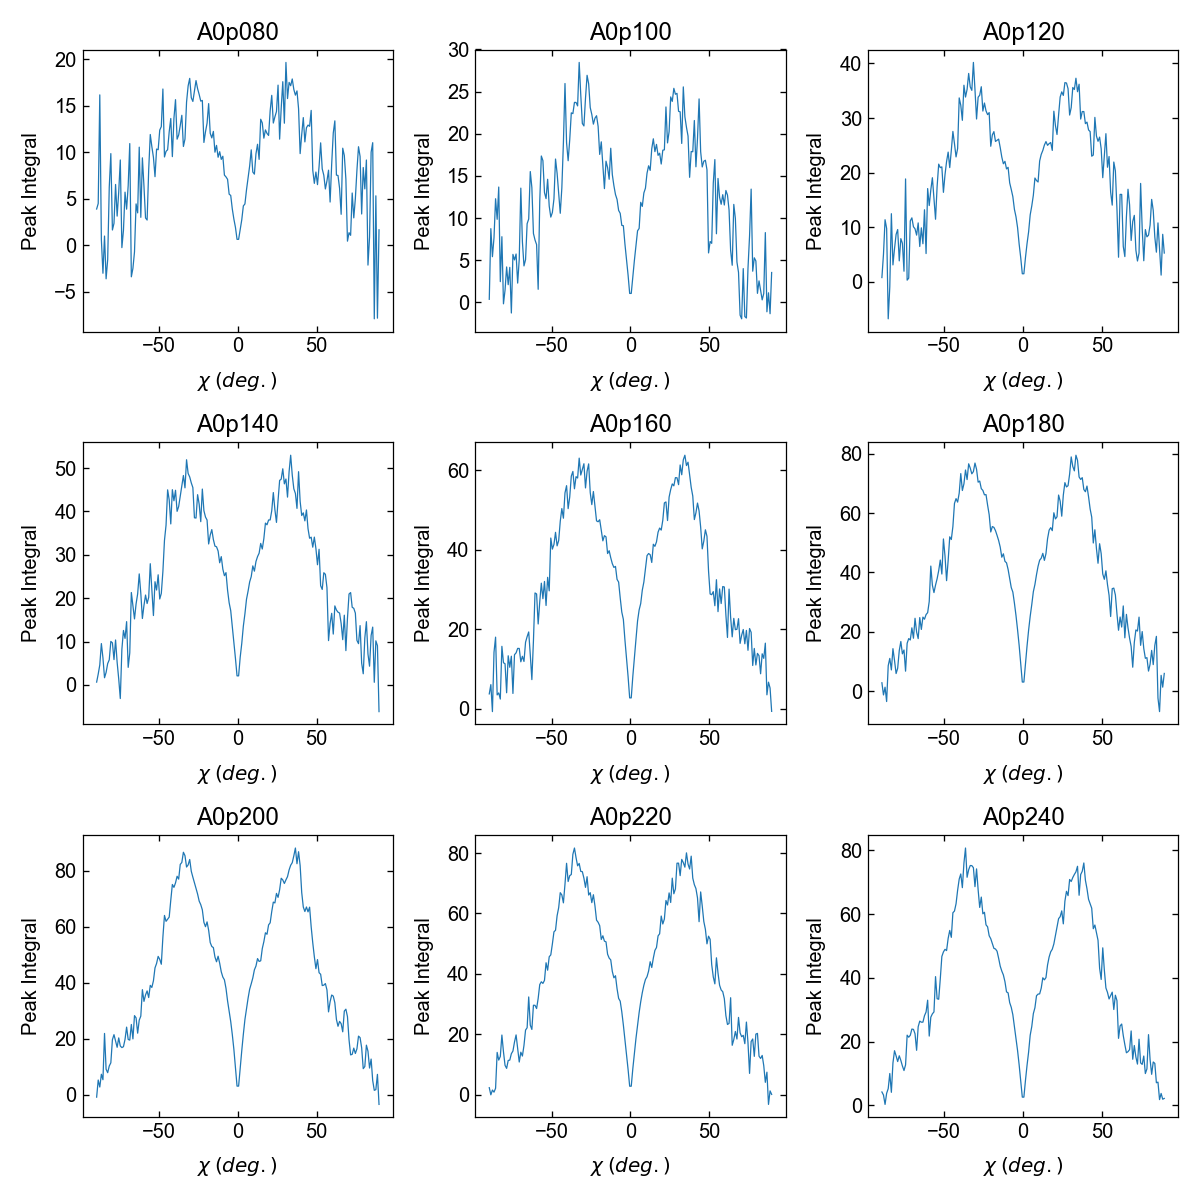

In [148]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, file in enumerate(gb_glob):
    
    raw = np.fromfile(gb_glob[i], dtype=np.float32).reshape(im_shape)
    pg = setup_detector(raw)

    intensity, q_abs, chi = pg.transform_polar(raw, unit='A',
                                               npt=(180, 180),
                                               chi_range=(-90,90), q_range=(0,1.2),
                                               correctSolidAngle=True,
                                               method='splitpix')

    vmin, vmax = np.percentile(intensity, (1,99))
    
    plt.subplot(3,3,i+1)
    
    qb = (0.275, 0.345)
    q_pix = np.array([np.where(q_abs>qb[0])[0][0], np.where(q_abs>qb[1])[0][0]])
    qbg = qb + np.array([-1, 1])*0.03
    q_bg_pix = np.array([np.where(q_abs>qbg[0])[0][0], np.where(q_abs>qbg[1])[0][0]])
    
    cut = intensity[:,q_pix[0]:q_pix[1]].sum(axis=1)/np.diff(q_pix) - np.mean(intensity[:,q_bg_pix], axis=1)

    plt.plot(chi,cut * np.abs(np.sin(chi * np.pi / 180)))
    plt.xlabel(r'$\chi \: (deg.)$')
    plt.ylabel("Peak Integral")
    plt.title(os.path.basename(file).split('_')[1])
    
plt.savefig('benzyl_poles_grid.png')

In [123]:
chi

array([-99.44444435, -98.33333324, -97.22222213, -96.11111102,
       -94.99999991, -93.8888888 , -92.77777769, -91.66666658,
       -90.55555547, -89.44444436, -88.33333325, -87.22222214,
       -86.11111103, -84.99999992, -83.88888881, -82.7777777 ,
       -81.66666659, -80.55555548, -79.44444437, -78.33333326,
       -77.22222215, -76.11111104, -74.99999993, -73.88888882,
       -72.77777771, -71.6666666 , -70.55555549, -69.44444438,
       -68.33333327, -67.22222216, -66.11111105, -64.99999994,
       -63.88888883, -62.77777772, -61.66666661, -60.5555555 ,
       -59.44444439, -58.33333328, -57.22222217, -56.11111106,
       -54.99999995, -53.88888884, -52.77777773, -51.66666662,
       -50.55555551, -49.4444444 , -48.33333329, -47.22222218,
       -46.11111107, -44.99999996, -43.88888885, -42.77777774,
       -41.66666663, -40.55555552, -39.44444441, -38.3333333 ,
       -37.22222219, -36.11111108, -34.99999997, -33.88888886,
       -32.77777775, -31.66666664, -30.55555553, -29.44

### Define a function to get the data for a row

In [4]:
def save_data(df_row, generate=False):
    
    base_path = os.path.splitext(df_row['fullpath'])[0]
    data_path = base_path+'_data.npy'
    dark_path = base_path+'_dark.npy'
    log_path = base_path+'_logimg.npy'
    
    if generate:
        data = fabio.open(df_row['fullpath']).data
        data = np.flipud(data)
        dark = np.flipud(fabio.open(df_row['darkfile']).data)

        pg = setup_detector(data, df_row['theta'])
        imgt, qxy, qz = pg.transform_reciprocal(data,
                                                method='lut',
                                                correctSolidAngle=True,
                                                unit='A',
                                                dark=dark)
        corrimg = imgt-np.min(imgt)+1
        logimg = np.log(corrimg)

        np.save(data_path, data)
        np.save(dark_path, dark)
        np.save(log_path, logimg)
    
    return data_path, dark_path, log_path

def get_data(df_row):
    data = np.load(df_row.datapath)
    dark = np.load(df_row.darkpath)
    logdata = np.load(df_row.logpath)
    
    return data, dark, logdata

### Parse file names and build master dataframe for results

In [5]:
def parse_filename(file):
    
    parts = file.split('_')
    parsed = pd.Series()
    
    parsed['solvent'] = parts[0]
    
    if 'spin' in parts:
        parsed['speed'] = 'spin'
        parsed['grooves'] = 'none'
        parsed['sample_phi'] = 'none'
    
    else:
        parsed['speed'] = parts[1]
        parsed['grooves'] = parts[2]
        parsed['sample_phi'] = parts[3]
        
    if 'ang' in parts:
        parsed['theta'] = float(parts[-1][-5]) * 0.02 + 0.06
        parsed['exp_time'] = 30
        
    else:
        parsed['theta'] = 0.12
        parsed['exp_time'] = 90
        
    return parsed

In [6]:
df_master = pd.DataFrame()

df_master['fullpath'] = pd.Series(globby)
df_master['filename'] = pd.Series([s[-1] for s in df_master['fullpath'].str.split('\\')])
df_master = pd.concat([df_master, df_master['filename'].apply(parse_filename)],
                      axis=1)
df_master['darkfile'] = df_master['exp_time'].apply(lambda t: dark30file if t==30
                                                else dark90file)

df_master['samplename']=['_'.join(s[:4]) for s in df_master['filename'].str.split('_')]
df_master['specnum'] = [int(s[-1].strip('.tif')) for s in df_master['filename'].str.split('_')]
df_master['sample_phi'] = df_master['sample_phi'].str.replace('90b','0')

print('file names parsed')

# Comment this line out if you've already done
df_master['datapath'], df_master['darkpath'], df_master['logpath'] = \
    zip(*df_master.apply(save_data, axis=1))

df_master

file names parsed


,fullpath,filename,solvent,speed,grooves,sample_phi,theta,exp_time,darkfile,samplename,specnum,datapath,darkpath,logpath
0,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...,cb_hi_nogr_0_01190534_0001.tif,cb,hi,nogr,0,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,cb_hi_nogr_0,1,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...
1,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...,cb_hi_nogr_0_01190534_0002.tif,cb,hi,nogr,0,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,cb_hi_nogr_0,2,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...
2,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,cb_hi_nogr_0_ang_01190531_0001.tif,cb,hi,nogr,0,0.08,30,F:\N2200 Project\data\ssrl\dark30_01190713_000...,cb_hi_nogr_0,1,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...
3,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,cb_hi_nogr_0_ang_01190531_0002.tif,cb,hi,nogr,0,0.10,30,F:\N2200 Project\data\ssrl\dark30_01190713_000...,cb_hi_nogr_0,2,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...
4,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,cb_hi_nogr_0_ang_01190531_0003.tif,cb,hi,nogr,0,0.12,30,F:\N2200 Project\data\ssrl\dark30_01190713_000...,cb_hi_nogr_0,3,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...
5,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,cb_hi_nogr_0_ang_01190531_0004.tif,cb,hi,nogr,0,0.14,30,F:\N2200 Project\data\ssrl\dark30_01190713_000...,cb_hi_nogr_0,4,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...
6,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,cb_hi_nogr_0_ang_01190531_0005.tif,cb,hi,nogr,0,0.16,30,F:\N2200 Project\data\ssrl\dark30_01190713_000...,cb_hi_nogr_0,5,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_a...
7,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,cb_hi_nogr_90_01190525_0001.tif,cb,hi,nogr,90,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,cb_hi_nogr_90,1,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...
8,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,cb_hi_nogr_90_01190525_0002.tif,cb,hi,nogr,90,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,cb_hi_nogr_90,2,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...
9,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,cb_hi_nogr_90_ang_01190521_0001.tif,cb,hi,nogr,90,0.08,30,F:\N2200 Project\data\ssrl\dark30_01190713_000...,cb_hi_nogr_90,1,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...,F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_90_...


### Show raw detector data in log scale

### Setup detector and sample geometry, Get qz-qxy data

In [7]:
def show_sample(sample, df_master, newfig=True):
    
    logimg = np.load(df_master['logpath'].loc[sample])
    clim = np.percentile(logimg[logimg>0], (0.5, 99.9))
    
    ppl.implot(logimg, qxy, qz,
               mode='rsma', cmap="terrain", clim=clim,
               xlim=(-.6,2), ylim=(-0.05,2), newfig=newfig)

In [8]:
# show_sample(0,df_master)

### Define some peak fitting and plotting functions

In [9]:
def plot_peak_fits(x,y,df_peaks,out_dict):

    color_list = ['#3cb44b','#0082c8','#f58231','#911eb4','#800000','#000080','#808000']
    f1 = plt.figure()
    plt.semilogy(x, y, 'r-')
    
    for i in df_peaks['set'].unique():
        
        out = out_dict[i]
        df_set = df_peaks.loc[df_peaks.set==i]
        
        # Build bounded x and y vectors
        lb = df_set.iloc[0].lb
        ub = df_set.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Add peaks to plot
        comps = out.eval_components(x=xb)
        plt.semilogy(xb, out.eval(x=xb), '-', color = color_list[i])
        for c in comps:
            try:
                plt.semilogy(xb, comps[c], '--', color = color_list[i])
            except:
                const_eval = np.ones(xb.shape)*comps[c]
                plt.semilogy(xb, const_eval, '--', color = color_list[i])

    # Show the plot
    f1.axes[0].set_ylim( bottom=max(1,np.min(y)/10), top=np.max(y)*1.3 )
    plt.show()

In [10]:
def fit_sector_peaks(df_row,chi,df_peak_init,chi_width=4,radial_range=(1.35,20)):
    
    data, dark, _ = get_data(df_row)
    theta = df_row.theta
    df_new = df_peak_init.copy()
    
    # Get I vs Q for angle d
    y, x = pg.profile_sector(data, npt=1000, chi_pos=chi,
                                     chi_width=chi_width, radial_range=radial_range,
                                     correctSolidAngle=True,
                                     method='lut', dark=dark)
    
    out_dict = {}
    
    # Run peak fits for each set of peaks
    for i in df_new['set'].unique():
        
        df_peaks = df_new.loc[df_new.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []

        if i not in [1,2]:
            lin_mod = ConstantModel(prefix='lin_')
            pars = lin_mod.make_params(c=yb.min())
            comp_mod.append(lin_mod)
        else:
            lin_mod = ExponentialModel(prefix='lin_')
            pars = lin_mod.guess(y,x=x)
            comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update(peak_temp.make_params())
            pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sig'])
            pars[prefix+'amplitude'].set(peak['amp'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df_new.loc[df_new.name==peak,prop] = params_dict[peak+'_'+prop]
        df_new['chi'] = chi
        out_dict[i] = out
        
    return df_new, out_dict, x, y

### Get in-plane sector

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


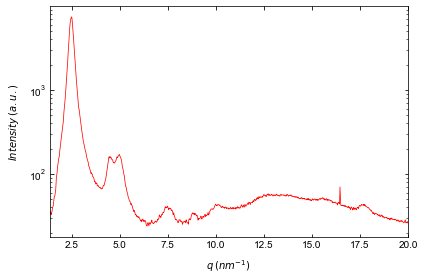

In [11]:
data = np.load(df_master.iloc[0].datapath)
dark = np.load(df_master.iloc[0].darkpath)
pg = setup_detector(data, df_master.iloc[0].theta)
int_sect, q_sect = pg.profile_sector(data, npt=1000, chi_pos=86,
                                 chi_width=4, radial_range=(1.35, 20),
                                 correctSolidAngle=True,
                                 method='lut', dark=dark)
ppl.plot(q_sect,int_sect, logy=True)

### Run peak fits over sectors starting from 88 back to 5 deg.
Initialize each fit from previous parameters

### Perform composite peak fits

In [12]:
p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.0, 'max': 3.0, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.0, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.5, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

p300 = {'name': 'p300', 'set':4, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 19.5}

p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 19.5}
p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

phalo ={'name': 'phalo', 'set':4, 'cent': 14, 'min': 12, 'max': 15, 'sig': 0.2, 'amp': 10, 'lb': 14, 'ub': 19.5}
p010 = {'name': 'p010', 'set':4, 'cent': 16.0, 'min': 15.2, 'max': 16.5, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}
p002a ={'name': 'p002a','set':4, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}

df_peak_init = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p400,phalo,p010,p002a]) #p002
df_peak_init

,amp,cent,lb,max,min,name,set,sig,ub
0,1000,2.3,1.5,3.0,2.0,p100,1,0.1,3.8
1,30,4.5,3.8,4.7,4.0,p001,2,0.1,5.7
2,30,4.9,3.8,5.5,4.7,p200,2,0.1,5.7
3,10,7.4,6.4,8.0,7.0,p300,4,0.1,19.5
4,10,8.8,8.4,9.0,8.6,p001a,4,0.1,19.5
5,10,9.9,8.4,10.3,9.7,p400,4,0.1,11.0
6,10,14.0,14.0,15.0,12.0,phalo,4,0.2,19.5
7,10,16.0,14.0,16.5,15.2,p010,4,0.1,19.5
8,10,17.7,14.0,18.0,17.2,p002a,4,0.1,19.5


C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


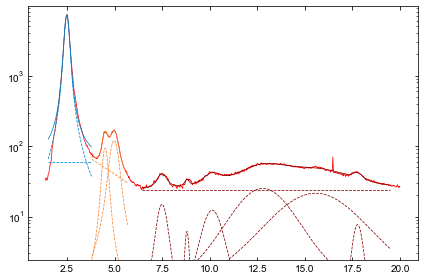

In [13]:
df_pex, out_dict_ex, x, y = fit_sector_peaks(df_master.loc[0],86,df_peak_init)
plot_peak_fits(x,y,df_pex,out_dict_ex)

### Write a master function to automate analysis

In [14]:
def Hermans(ii, chi):
    sin_chi = np.sin(np.deg2rad(chi))
    cos2chi = np.cos(np.deg2rad(chi)) ** 2
    return np.sum(ii * cos2chi * sin_chi) / np.sum(ii * sin_chi)

def interp_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

In [15]:
def analyze_n22(df_row, df_peak_init, chi_pos=86):
    
    data, dark, _ = get_data(df_row)
    pg = setup_detector(data,df_row.theta)
    df_res = df_row.copy()
    
    # Store results of peak fits in df_res
    df_pf, out_dict, _, _ = fit_sector_peaks(df_row,chi_pos,df_peak_init,chi_width=4,radial_range=(1.35,20))
    df_res['peak_fits'] = df_pf
    df_res['out_dict'] = out_dict
    
    # Get Herman's Orientation and store
    p100_q = df_pf.loc[df_pf['name']=='p100', 'center'].iloc[0]
    
    cake, chi = pg.profile_chi(data, npt=200,
                               radial_pos=p100_q, radial_width=.3,
                               chi_range=(3,86),
                               correctSolidAngle=True,
                               method='lut', dark=dark)
    
    df_res['Hermans'] = Hermans(interp_nans(cake),chi)
    
    return df_res

In [17]:
analyze_n22(df_master.loc[0],df_peak_init)

fullpath      F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...
filename                         cb_hi_nogr_0_01190534_0001.tif
solvent                                                      cb
speed                                                        hi
grooves                                                    nogr
sample_phi                                                    0
theta                                                      0.12
exp_time                                                     90
darkfile      F:\N2200 Project\data\ssrl\dark90_01190715_000...
samplename                                         cb_hi_nogr_0
specnum                                                       1
datapath      F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...
darkpath      F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...
logpath       F:\N2200 Project\data\ssrl\waxs\cb_hi_nogr_0_0...
peak_fits         amp  cent    lb   max   min   name  set  s...
out_dict      {1: <lmfit.model.ModelResu

In [24]:
df_res = pd.DataFrame()
df_analysis = df_master.loc[[94,101,108,122,129,131,138,145]]
df_analysis

,fullpath,filename,solvent,speed,grooves,sample_phi,theta,exp_time,darkfile,samplename,specnum,datapath,darkpath,logpath
94,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_0_...,tol_hi_nogr_0_01190652_0002.tif,tol,hi,nogr,0,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_nogr_0,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_0_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_0_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_0_...
101,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...,tol_hi_nogr_90b_01190639_0002.tif,tol,hi,nogr,0,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_nogr_90b,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...
108,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...,tol_hi_nogr_90_01190630_0002.tif,tol,hi,nogr,90,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_nogr_90,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...,F:\N2200 Project\data\ssrl\waxs\tol_hi_nogr_90...
122,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_0__...,tol_hi_par_0__01171334_0003.tif,tol,hi,par,0,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_par_0,3,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_0__...,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_0__...,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_0__...
129,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...,tol_hi_par_90__01171317_0002.tif,tol,hi,par,90,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_par_90,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...
131,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...,tol_hi_par_90__01171320_0002.tif,tol,hi,par,90,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_par_90,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_par_90_...
138,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_0_...,tol_hi_perp_0__01171546_0002.tif,tol,hi,perp,0,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_perp_0,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_0_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_0_...,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_0_...
145,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_90...,tol_hi_perp_90__01171536_0002.tif,tol,hi,perp,90,0.12,90,F:\N2200 Project\data\ssrl\dark90_01190715_000...,tol_hi_perp_90,2,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_90...,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_90...,F:\N2200 Project\data\ssrl\waxs\tol_hi_perp_90...


In [25]:
for i,r in df_analysis.iterrows():
    print('running {}'.format(r.samplename))
    try:
        new_row = analyze_n22(r,df_peak_init)
        df_res = df_res.append(new_row, ignore_index=True)
        print('Hermans = {}'.format(new_row['Hermans']))
    except:
        print('{} failed'.format(r.samplename))
        pass

running tol_hi_nogr_0
Hermans = 0.20811362410122947
running tol_hi_nogr_90b
Hermans = 0.2432396745267903
running tol_hi_nogr_90
Hermans = 0.2430949964464107
running tol_hi_par_0
Hermans = 0.19064970495381284
running tol_hi_par_90
Hermans = 0.36605006956855884
running tol_hi_par_90
Hermans = 0.3957792379878616
running tol_hi_perp_0
Hermans = 0.23692201494064874
running tol_hi_perp_90
Hermans = 0.18856427555206076


In [29]:
df_grouped = df_res.groupby('samplename').agg({'specnum':'max'})
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.rename(columns = {'specnum':'specnum_max'})
df_res2 = pd.merge(df_res, df_grouped, how='left', on='samplename')
df_res2 = df_res2[df_res2['specnum']==df_res2['specnum_max']]
# df_res2 = df_res2.drop([29,37])
df_res2['ratio_001_200'] = df_res2['peak_fits'].apply(lambda df: df['amplitude'].loc[df.name=='p100'].iloc[0] /
                                                                 df['amplitude'].loc[df.name=='p001'].iloc[0])
df_res2['amp100'] = df_res2['peak_fits'].apply(lambda df: df['amplitude'].loc[df.name=='p100'].iloc[0])
df_res2['amp001'] = df_res2['peak_fits'].apply(lambda df: df['amplitude'].loc[df.name=='p001'].iloc[0])

df_nospin = df_res2.loc[df_res2['grooves']!='none']
# df_nospin[['samplename','filename','ratio_001_200']]
df_res2[['samplename','filename','amp100','amp001','ratio_001_200','Hermans']]

,samplename,filename,amp100,amp001,ratio_001_200,Hermans
0,tol_hi_nogr_0,tol_hi_nogr_0_01190652_0002.tif,3931.018617,69.245991,56.768898,0.208114
1,tol_hi_nogr_90b,tol_hi_nogr_90b_01190639_0002.tif,493.101319,400.922687,1.229916,0.243240
2,tol_hi_nogr_90,tol_hi_nogr_90_01190630_0002.tif,493.511804,362.635616,1.360903,0.243095
3,tol_hi_par_0,tol_hi_par_0__01171334_0003.tif,6647.088537,0.532297,12487.565537,0.190650
4,tol_hi_par_90,tol_hi_par_90__01171317_0002.tif,2.509378,0.209755,11.963393,0.366050
5,tol_hi_par_90,tol_hi_par_90__01171320_0002.tif,22.025798,548.626338,0.040147,0.395779
6,tol_hi_perp_0,tol_hi_perp_0__01171546_0002.tif,1525.173648,291.631190,5.229803,0.236922
7,tol_hi_perp_90,tol_hi_perp_90__01171536_0002.tif,3545.501660,169.442346,20.924531,0.188564


NameError: name 'qxy' is not defined

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


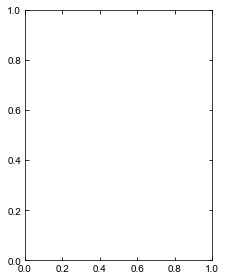

In [19]:
plt.subplot(1,2,1)
show_sample(47,df_res2)
plt.subplot(1,2,2)
show_sample(62,df_res2)

In [ ]:
peak_test = 23
angle = 86
df_pex, out_dict_ex, x, y = fit_sector_peaks(peak_test,df_nospin,angle,df_peak_init, chi_width=4)
plot_peak_fits(x,y,df_pex,out_dict_ex)

In [ ]:
show_sample(39,df_nospin)

In [ ]:
df_master.loc[peak_test]

In [ ]:
plt.figure()
plt.plot(df_nospin.ratio_001_200[::2],df_nospin.ratio_001_200[1::2],'ob')

In [ ]:
df_g2 = df_res2.groupby(['solvent','speed','grooves'])
df_res2['df_g2.apply(lambda df: df.loc[df['sample_phi']==90].iloc[0] / 
                        df.loc[df['sample_phi']==0].iloc[0])

In [ ]:
df_pole = pd.DataFrame()
df_prev = df_peak_init

for d in range(88,80,-2):
    
    print(d)
    df_curr = fit_sector_peaks(sample,df_master,d,df_prev,chi_width=4,radial_range=(1.35,20))
    df_pole = df_pole.append(df_curr)
    df_prev = df_curr

In [ ]:
df_pole[df_pole.chi==86]

In [ ]:
plt.figure()
plt.plot(df_pole[df_pole.name=='p100'].chi,df_pole[df_pole.name=='p100'].amplitude)

### Compute d-spacing, Herman's Orientation

In [ ]:
df['d-space']=2*np.pi / df['center'] * 10
df

### Chi-profile, radially integrated, for Herman's calculation

In [ ]:
p200_q = float(df['center'][df['name']=='p200'])

cake, chi = pg.profile_chi(data, npt=200,
                           radial_pos=p200_q, radial_width=.3,
                           chi_range=(-88,88),
                           correctSolidAngle=True,
                           method='lut', dark=dark)

ppl.plot(chi,np.abs(interp_nans(cake) * np.sin(np.deg2rad(chi))),mode='chi')
print('Hermans Orientation Factor: ', Hermans(interp_nans(cake),chi))

### q-chi map, just because it's possible

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':
C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


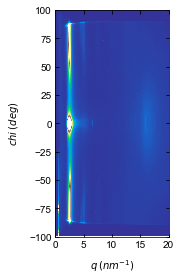

(<matplotlib.figure.Figure at 0xb98a898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x166b31d0>)

In [14]:
intensity, q_abs, chi = pg.transform_polar(data,
                                           npt=(2000, 400), q_range=(0,20),
                                           correctSolidAngle=True,
                                           method='splitpix', dark=dark)

ppl.implot(intensity, q_abs, chi, mode='polar', cmap='terrain', clim=np.percentile(intensity,(0.1,99.5)))

### Generate cropped, processed spectrum for all files

Previous cells must have been run for this to work.

In [ ]:
for ind,row in df_master.iterrows():
    
    data = fabio.open(row['fullpath']).data
    data = np.flipud(data)
    
    if row['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)

    imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=dark)
    corrimg = imgt-np.min(imgt)+1
    logimg = np.log(corrimg)
    
    figfile = (row['fullpath'].split('.')[:-1][0]+'.png').replace('data','figures')
    print(figfile)
    clim = np.percentile(logimg[logimg>0], (0.5, 99.9))
    ppl.implot(logimg,qxy,qz,mode='rsma',cmap='terrain',clim=clim,xlim=(-.6,2),ylim=(-.05,2),show=False,filename=figfile)
    plt.close()

In [ ]:
df_res.to_csv(path_or_buf='n22_waxs_results.csv')

In [ ]:
df_res.to_pickle('n22_waxs_pickle')

In [ ]:
df_new = pd.read_pickle('n22_waxs_pickle')
df_new

In [ ]:
df_new